In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# --- Basic Configuration ---
data_dir = 'dataset/soil_dataset'
img_height = 224
img_width = 224
batch_size = 32

# --- Load Training Data ---
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# --- Load Validation Data ---
validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Found the following classes:", class_names)

Found 656 files belonging to 8 classes.
Using 591 files for training.
Found 656 files belonging to 8 classes.
Using 65 files for validation.
Found the following classes: ['Alluvial Soil', 'Black Soil', 'Cinder Soil', 'Clay Soil', 'Laterite Soil', 'Peat Soil', 'Red Soil', 'Yellow Soil']


In [ ]:
# --- Create a Data Augmentation Layer ---
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

# --- Configure the dataset for performance ---
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# --- Load the pre-trained ResNet50 model ---
base_model = tf.keras.applications.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

# --- Freeze the base model ---
base_model.trainable = False

# --- Build the full model ---
inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs)

# --- Print a summary of the model architecture ---
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │     16,392 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,604,104 (90.04 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [4]:
# --- Compile the model ---
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# --- Train the model ---
epochs = 50
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5939 - loss: 1.7815 - val_accuracy: 0.6769 - val_loss: 1.0288
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8206 - loss: 0.6757 - val_accuracy: 0.8615 - val_loss: 0.6898
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8883 - loss: 0.3458 - val_accuracy: 0.8308 - val_loss: 1.0599
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9120 - loss: 0.3164 - val_accuracy: 0.7692 - val_loss: 1.0879
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9002 - loss: 0.3559 - val_accuracy: 0.8615 - val_loss: 0.8213
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9425 - loss: 0.1822 - val_accuracy: 0.8462 - val_loss: 0.7692
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9340 - loss: 0.2188 - val_accuracy: 0.8308 - val_loss: 0.8906
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9323 - loss: 0.2222 - val_accuracy: 0.7231 - val_loss:

Accuracy :  0.9678511023521423


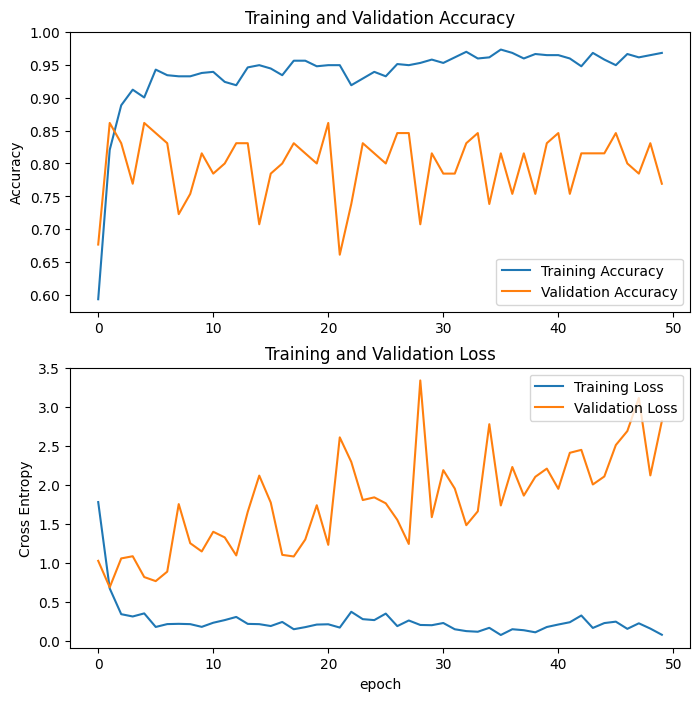

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print("Accuracy : ", acc[-1])

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [6]:
import tensorflow as tf

model.save('model_outputs/soil_classifier_model.keras')

print("✅ Model saved successfully!")

✅ Model saved successfully!


In [7]:
loaded_model = tf.keras.models.load_model('model_outputs/soil_classifier_model.keras')
print("✅ Model loaded successfully!")

loaded_model.summary()

✅ Model loaded successfully!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │     16,392 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,636,890 (90.17 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 32,786 (128.07 KB)

In [8]:
import tensorflow as tf
import numpy as np

image_path = 'dataset/dummies/black.jpg' # <--- IMPORTANT: CHANGE THIS PATH

try:
    img = tf.keras.utils.load_img(
        image_path, target_size=(224, 224)
    )

    img_array = tf.keras.utils.img_to_array(img)

    img_batch = tf.expand_dims(img_array, 0) 


    prediction = loaded_model.predict(img_batch)
    score = tf.nn.softmax(prediction[0]) # Get probabilities

    # 4. DISPLAY THE RESULT ✅
    predicted_class_index = np.argmax(score)
    predicted_class_name = class_names[predicted_class_index]
    confidence = 100 * np.max(score)

    print(f"This image most likely belongs to the class: '{predicted_class_name}'")
    print(f"Confidence: {confidence:.2f}%")

except FileNotFoundError:
    print(f"Error: The file was not found at '{image_path}'. Please check the path and try again.")
except Exception as e:
    print(f"An error occurred: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
This image most likely belongs to the class: 'Alluvial Soil'
Confidence: 27.97%
